In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8) 

from statsmodels.tsa.stattools import adfuller

In [2]:
data = pd.read_csv('../SPY.csv', index_col='Date', parse_dates=True)

In [3]:
df = data.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2263 entries, 2010-01-04 to 2018-12-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2263 non-null   float64
 1   High       2263 non-null   float64
 2   Low        2263 non-null   float64
 3   Close      2263 non-null   float64
 4   Adj Close  2263 non-null   float64
 5   Volume     2263 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 123.8 KB


In [5]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,92.246048,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.490204,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.555328,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.946060,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,93.255348,126402800
...,...,...,...,...,...,...
2018-12-21,246.740005,249.710007,239.979996,240.699997,234.845886,255345600
2018-12-24,239.039993,240.839996,234.270004,234.339996,228.640564,147311600
2018-12-26,235.970001,246.179993,233.759995,246.179993,240.192596,218485400


Делю датасет на тренировочную и тестовую части

In [6]:
N_split = 2000
train = df.iloc[:N_split]['Close']
test = df.iloc[N_split:]['Close']

Визуализирую разбиение выборки на графике

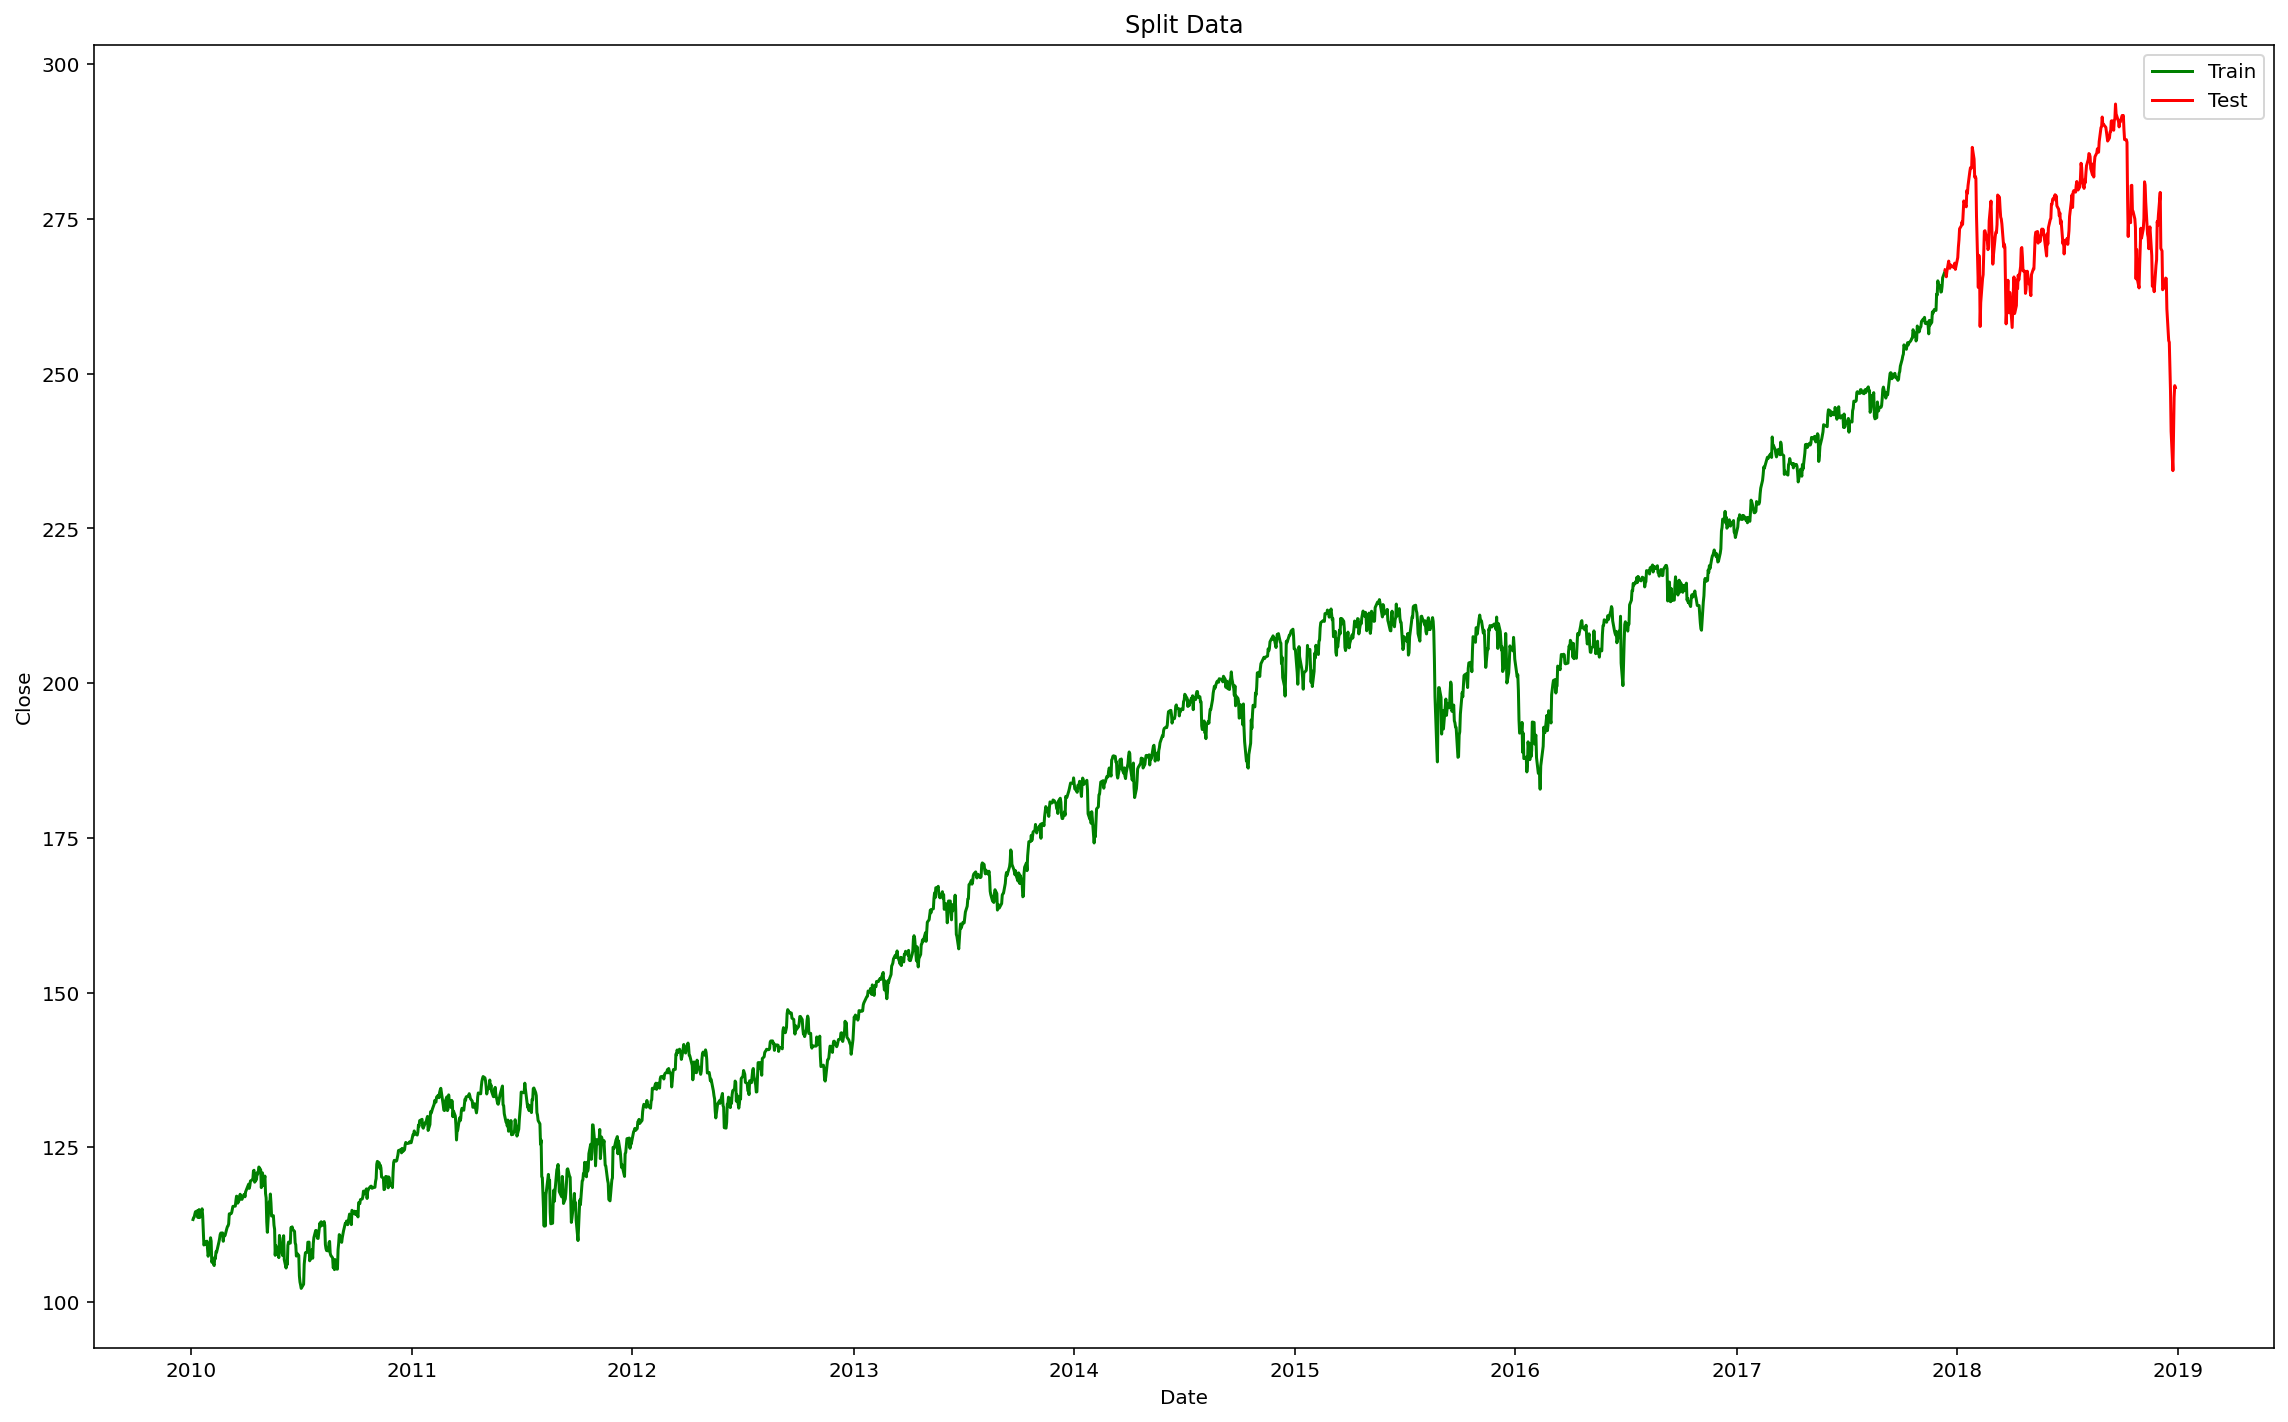

In [7]:
fig, ax = plt.subplots(figsize=(16, 10))

# Convert index and columns to NumPy arrays
index_train = train.index.to_numpy()
close_train = train.to_numpy()
index_test = test.index.to_numpy()
close_test = test.to_numpy()

ax.plot(index_train, close_train, label='Train', color='green')
ax.plot(index_test, close_test, label='Test', color='red')
ax.set_title('Split Data')

plt.ylabel('Close')
plt.xlabel('Date')

plt.legend()
plt.tight_layout()
plt.show()

- Трасформирую временные ряды в датасеты с векторами признаков. 
- В качестве признаков беру два последних значения цены в ряду (т.е. цена вчера и сегодня), для предсказания следующего значения (цена завтра)
- Вектор только из 2х признаков для удобной визуализации их зависимости на графике.

In [8]:
train = train.to_numpy()
test = test.to_numpy()

In [9]:
X_train = []
for t in range(len(train) - 1):
    x0 = train[t]
    x1 = train[t + 1]
    X_train.append((x0, x1))

In [10]:
X_test = []
for t in range(len(test) - 1):
    x0 = test[t]
    x1 = test[t + 1]
    X_test.append((x0, x1))

In [11]:
X_train = np.array(X_train)
X_test = np.array(X_test)

# Подпространства признаков
Разделенные по train/test выборка цветами

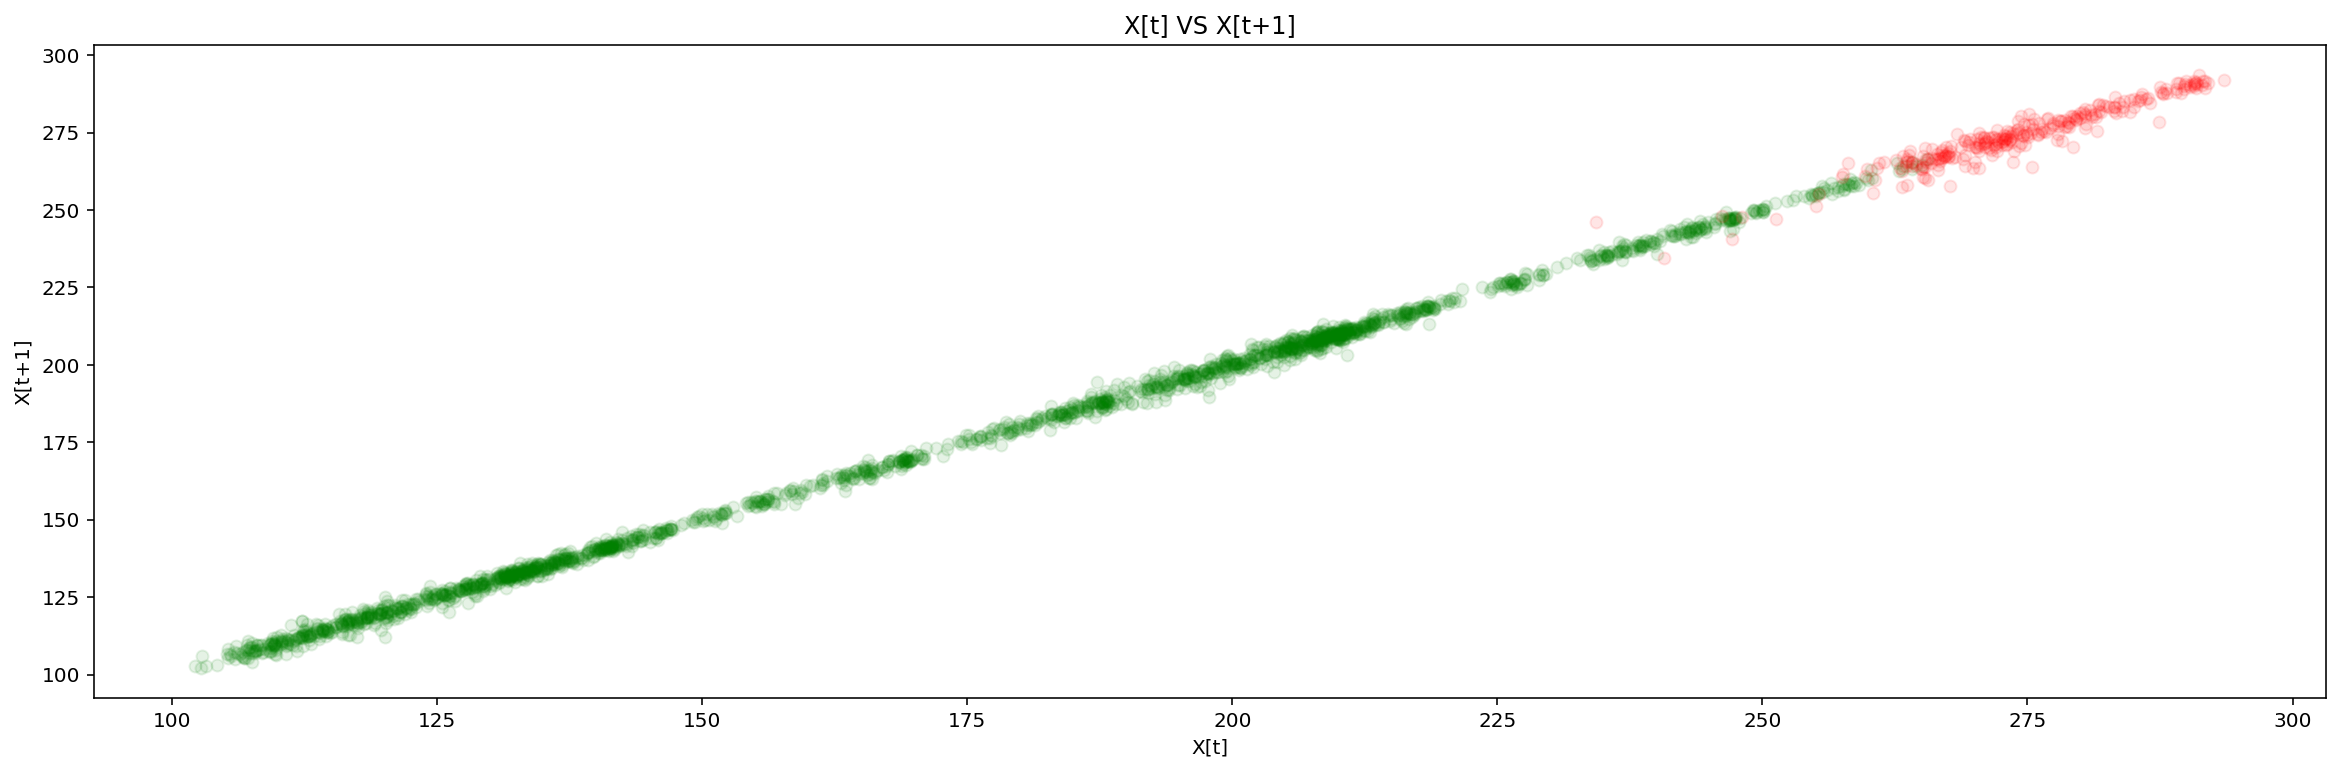

In [12]:
plt.figure(figsize=(20, 6))
plt.xlabel('X[t]')
plt.ylabel('X[t+1]')
plt.title('X[t] VS X[t+1]')
plt.scatter(x=X_train[:,[0]], y=X_train[:,[1]], color='green', alpha=0.1)
plt.scatter(x=X_test[:,[0]], y=X_test[:,[1]], color='red', alpha=0.1)
plt.show()

Что видно:
- Признаки из тренировочного и тестового набора лежат в разных пространствах признаков
- Алгоритм не может экстраполировать цену, он не знает будущего, он всего лишь может с помощью коэффициентов описать то пространство признаков, которое он видел на тренировочной выборке

### А что если попробовать нормализовать данные
Пробую MinMaxScaler для начала, он вообще не должен работать. Я ведь буду использовать сырые данные и 

In [13]:
N_split = 2000
train = df.iloc[:N_split][['Close']]
test = df.iloc[N_split:][['Close']]

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler().set_output(transform='pandas')

In [16]:
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [17]:
train = train['Close']
test = test['Close']

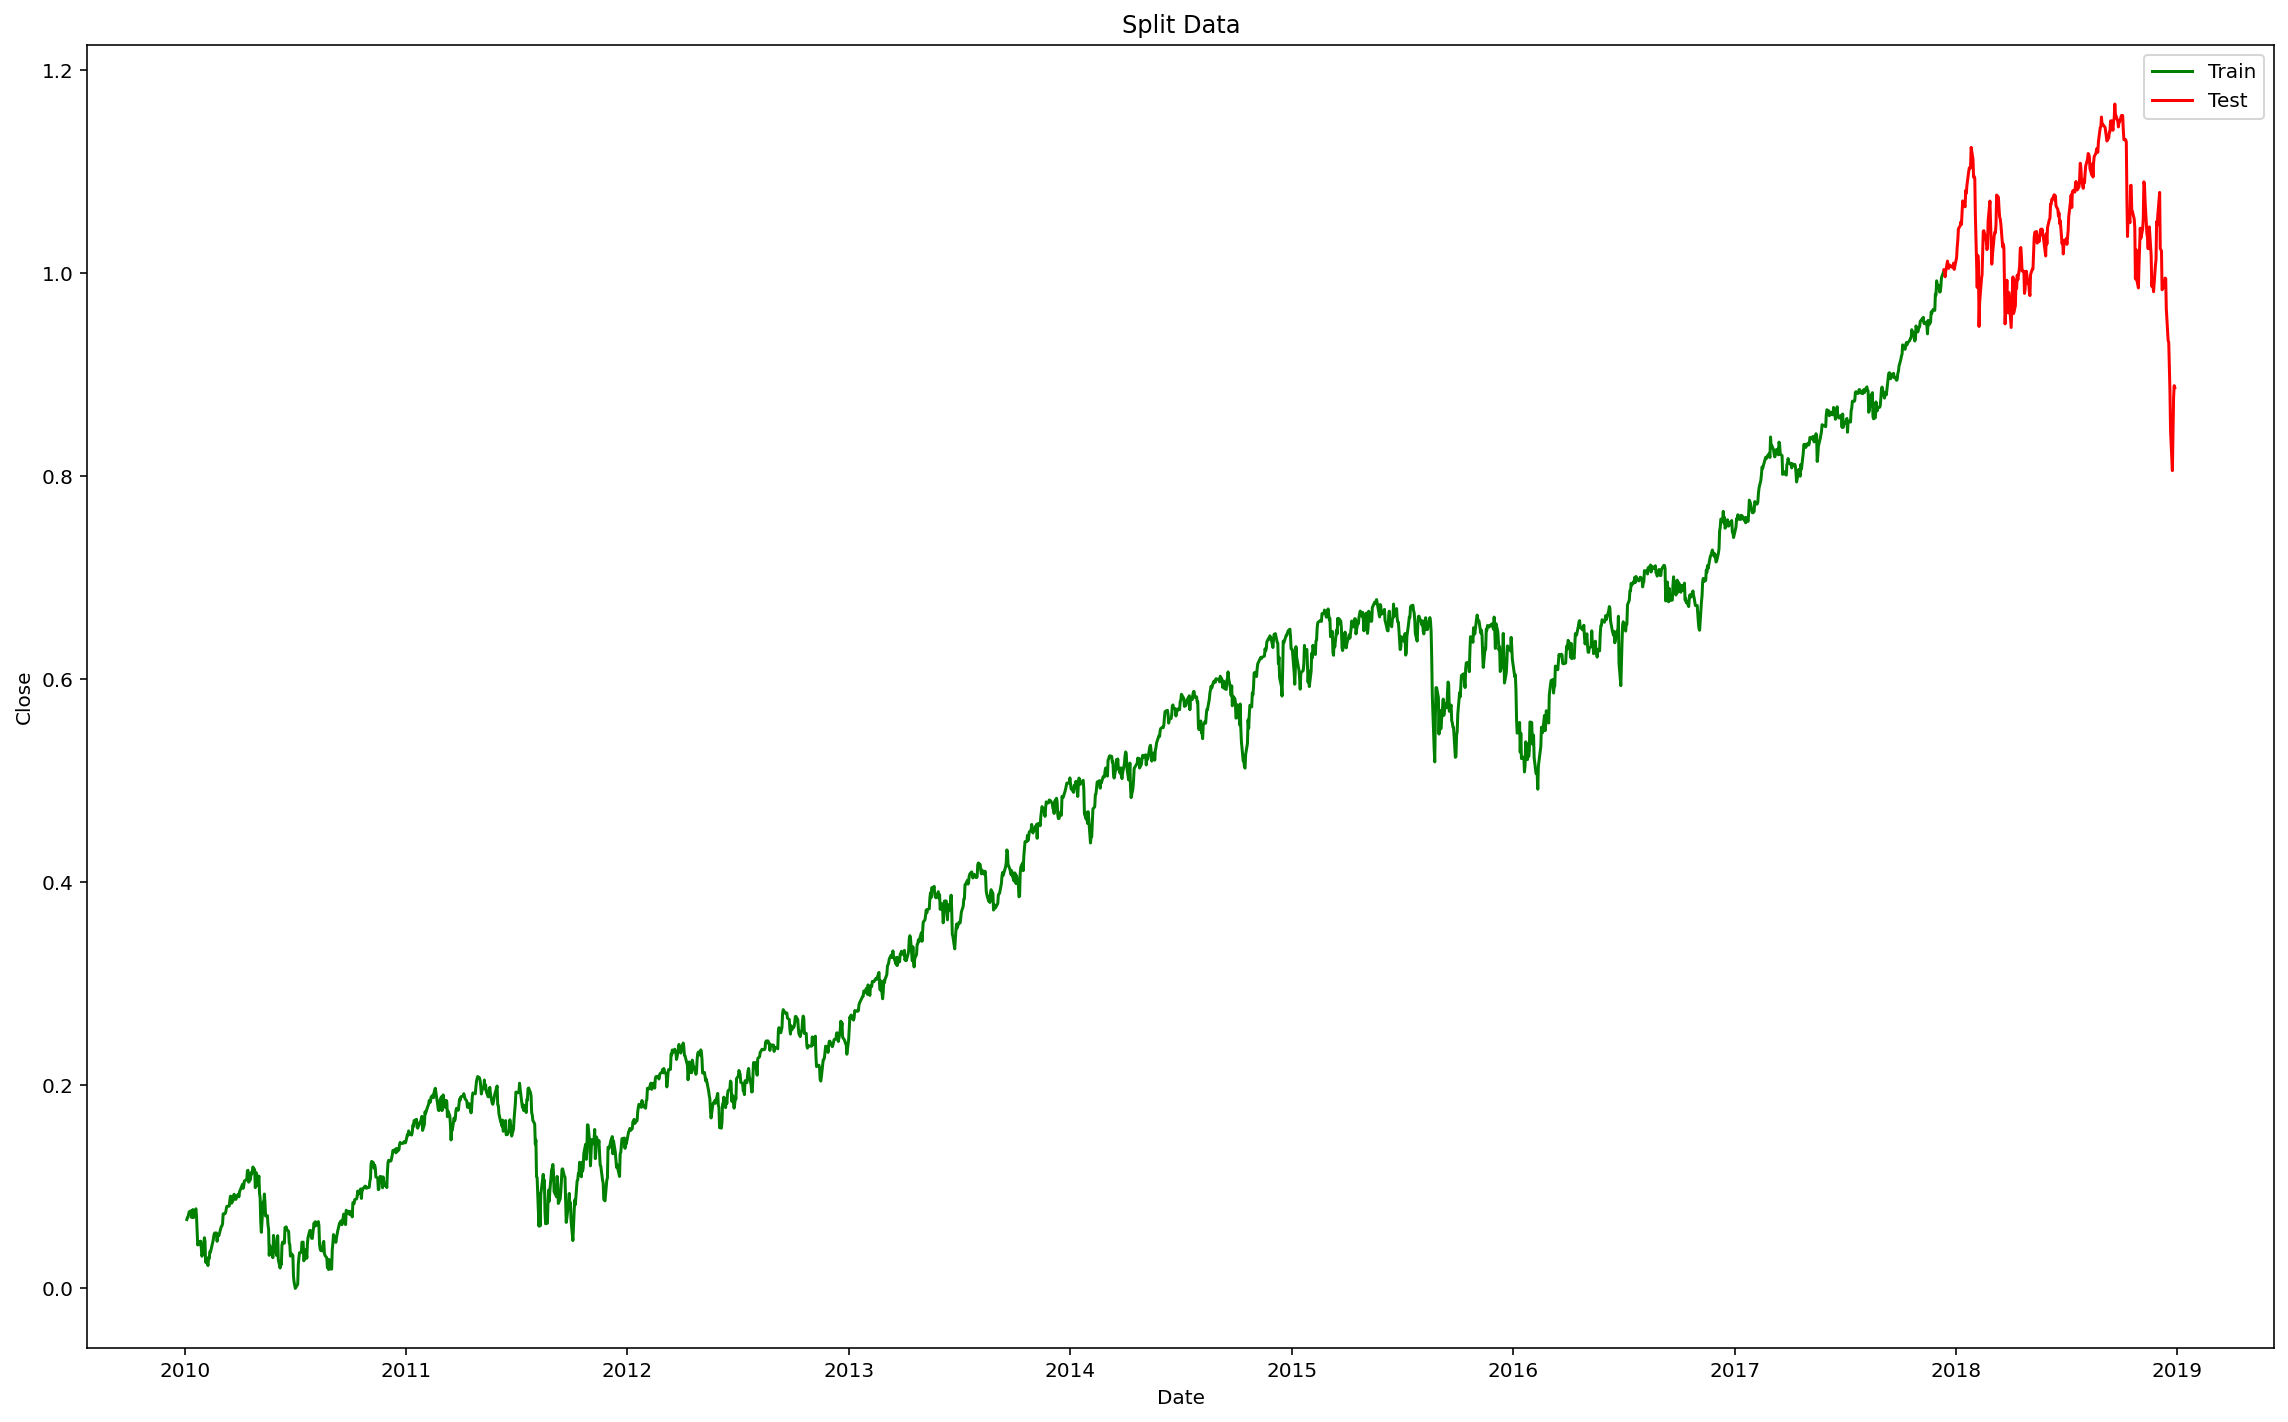

In [18]:
fig, ax = plt.subplots(figsize=(16, 10))

# Convert index and columns to NumPy arrays
index_train = train.index.to_numpy()
close_train = train.to_numpy()
index_test = test.index.to_numpy()
close_test = test.to_numpy()

ax.plot(index_train, close_train, label='Train', color='green')
ax.plot(index_test, close_test, label='Test', color='red')
ax.set_title('Split Data')

plt.ylabel('Close')
plt.xlabel('Date')

plt.legend()
plt.tight_layout()
plt.show()

Что я вижу после использования MinMaxScaler. А вижу я что график вообще не поменялся. И если тренировочная часть заканчивалась на максимуме и после скалирования там было значение 1, то тестовая часть была трасформирована так, что ее макс значение подошло к 1.2.
Временной ряд не был нормализован, наблюдается тренд. Скалер ничего с этим сделать не может.

Скалеры нужны, что бы привести разные признаки к одной шкале. А не что бы один признак на разных выборках как-то уровнять. Скалер не может справиться с трендовой составляющей.

In [19]:
train = train.to_numpy()
test = test.to_numpy()

In [20]:
X_train = []
for t in range(len(train) - 1):
    x0 = train[t]
    x1 = train[t + 1]
    X_train.append((x0, x1))

In [21]:
X_test = []
for t in range(len(test) - 1):
    x0 = test[t]
    x1 = test[t + 1]
    X_test.append((x0, x1))

In [22]:
X_train = np.array(X_train)
X_test = np.array(X_test)

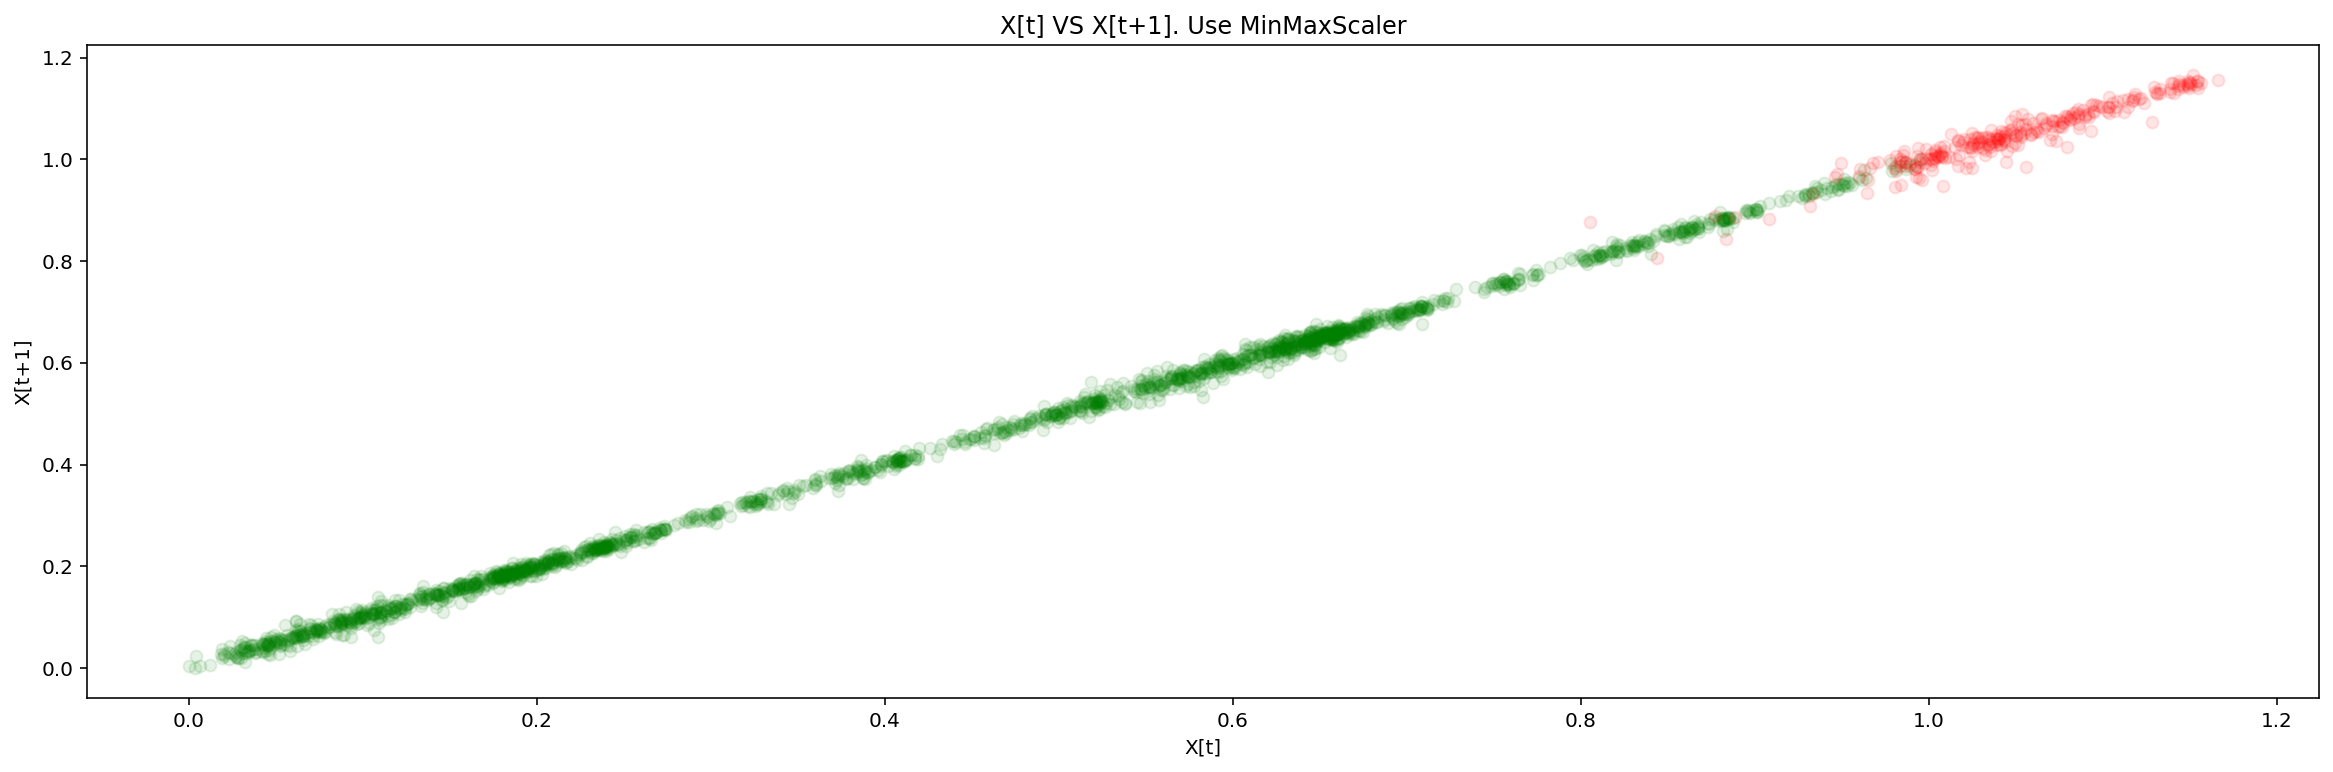

In [23]:
plt.figure(figsize=(20, 6))
plt.xlabel('X[t]')
plt.ylabel('X[t+1]')
plt.title('X[t] VS X[t+1]. Use MinMaxScaler')
plt.scatter(x=X_train[:,[0]], y=X_train[:,[1]], color='green', alpha=0.1)
plt.scatter(x=X_test[:,[0]], y=X_test[:,[1]], color='red', alpha=0.1)
plt.show()

Видно что график совершенно не изменился, изменились лишь значения по осям. А пространства признаков как были, так и остались непересекающимися.

### Пробую StandartScaler

In [24]:
N_split = 2000
train = df.iloc[:N_split][['Close']]
test = df.iloc[N_split:][['Close']]

In [25]:
from sklearn.preprocessing import StandardScaler # среднее значение будет 0 и страндартное отклонение 1

In [26]:
scaler = StandardScaler().set_output(transform='pandas')

In [27]:
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [28]:
train = train['Close']
test = test['Close']

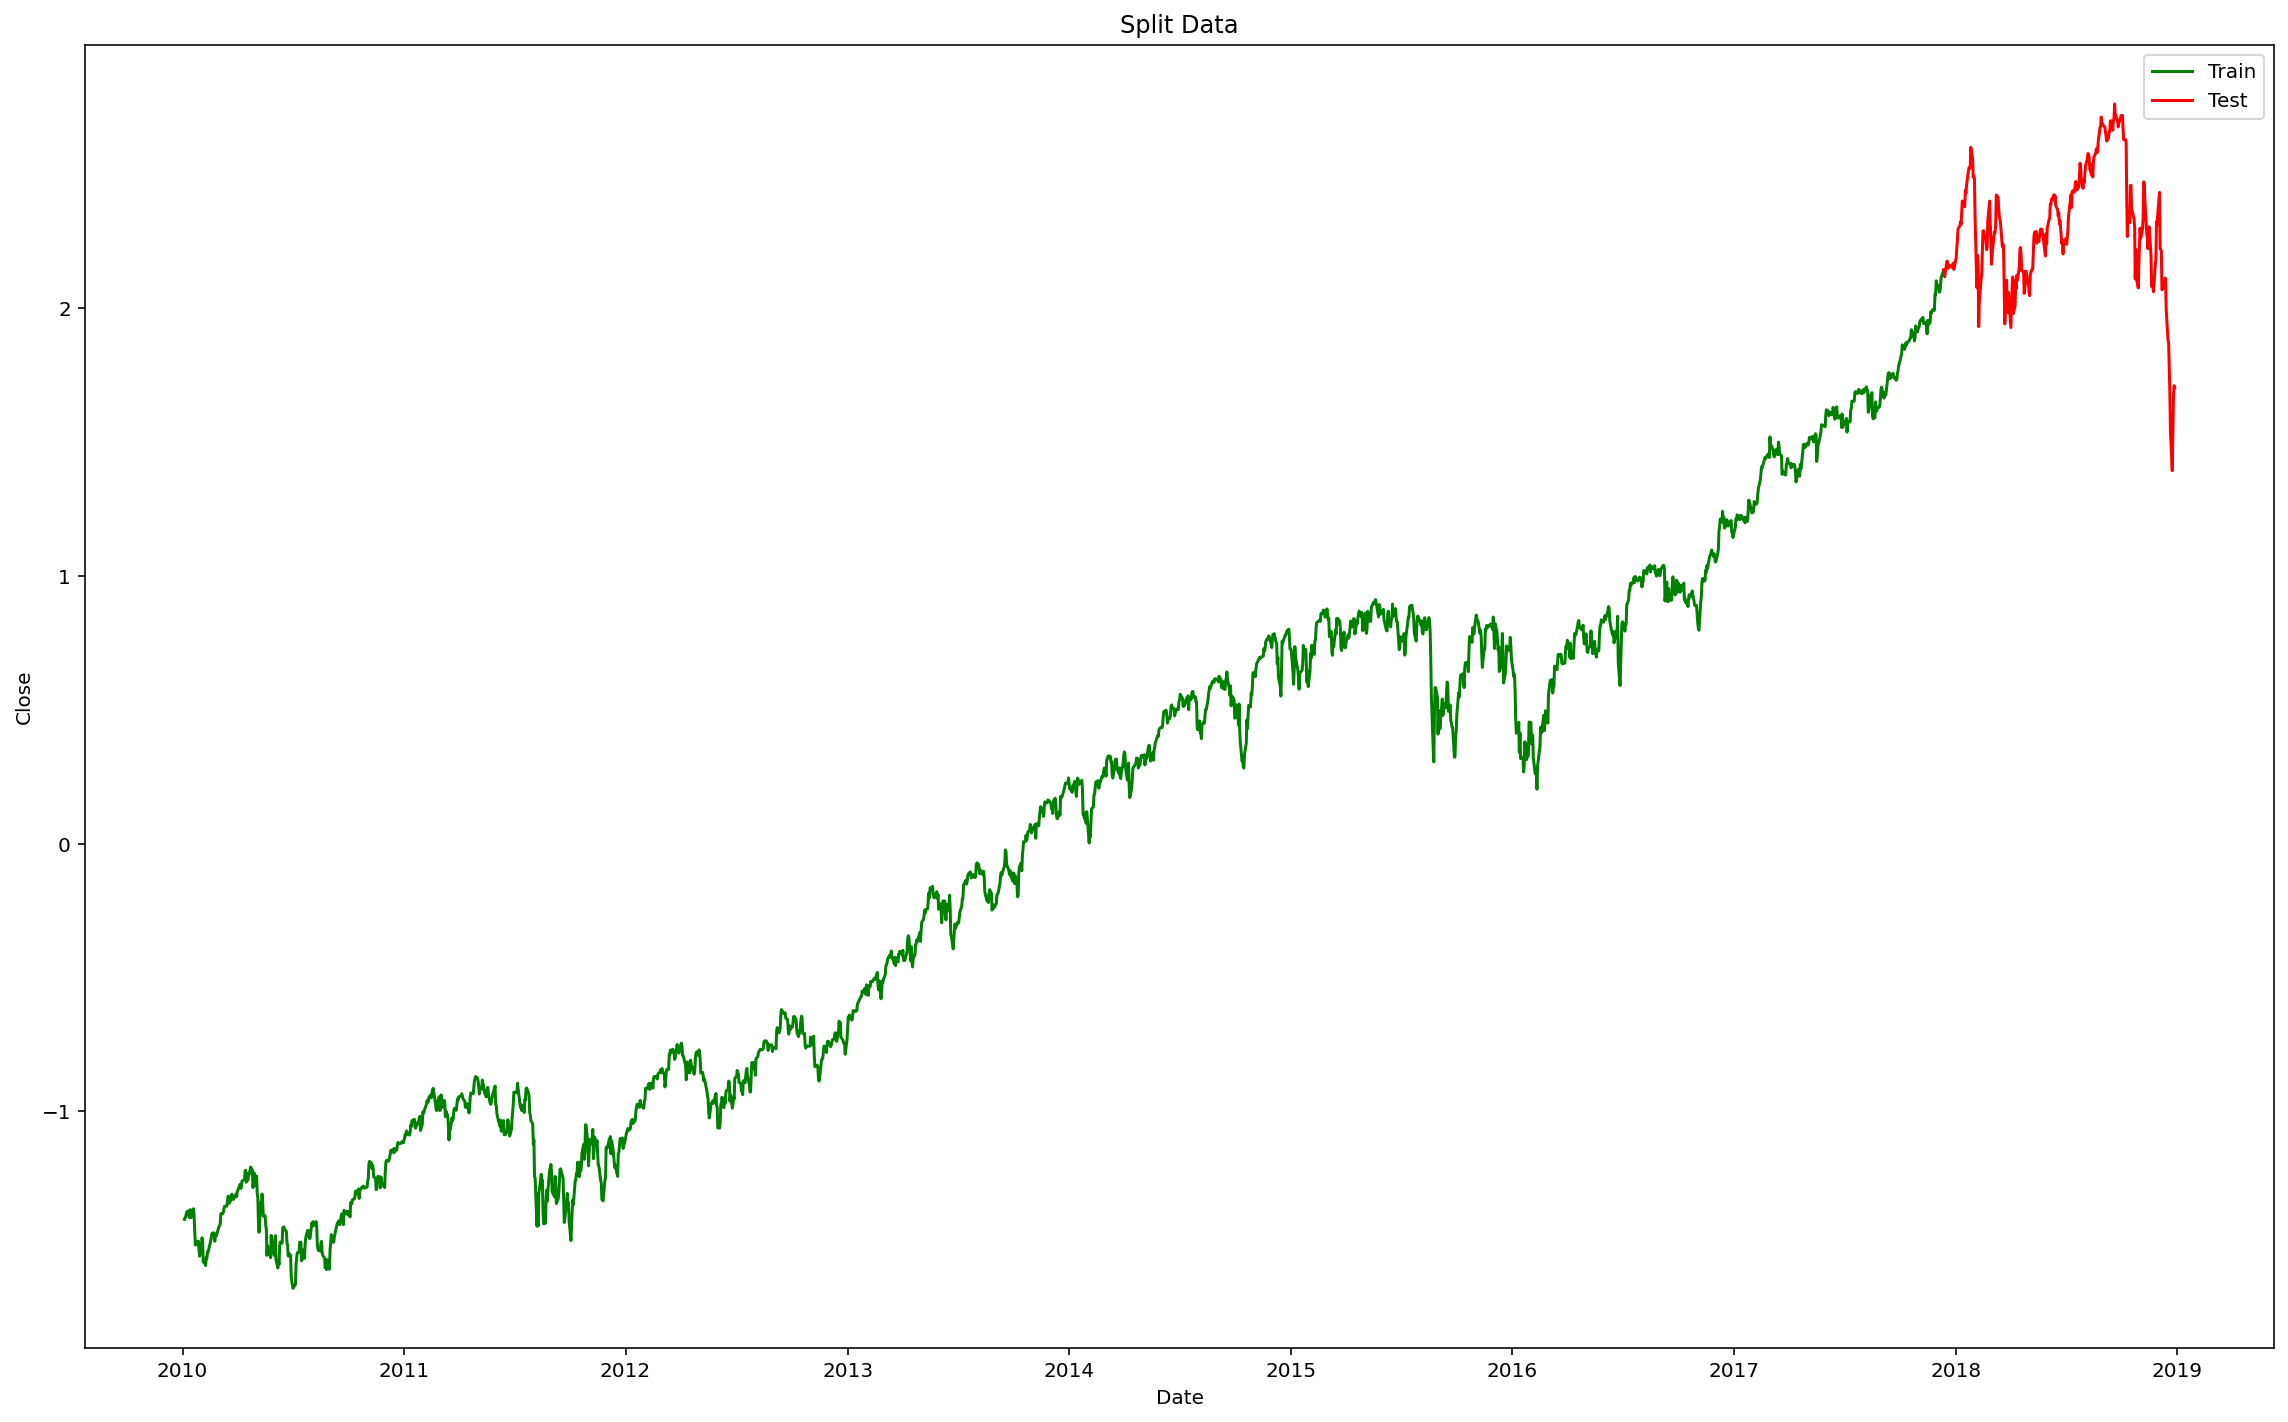

In [29]:
fig, ax = plt.subplots(figsize=(16, 10))

# Convert index and columns to NumPy arrays
index_train = train.index.to_numpy()
close_train = train.to_numpy()
index_test = test.index.to_numpy()
close_test = test.to_numpy()

ax.plot(index_train, close_train, label='Train', color='green')
ax.plot(index_test, close_test, label='Test', color='red')
ax.set_title('Split Data')

plt.ylabel('Close')
plt.xlabel('Date')

plt.legend()
plt.tight_layout()
plt.show()

Что я вижу после использования StandardScaler. А вижу я что график вообще не поменялся. И если тренировочная часть заканчивалась на максимуме и после скалирования там было значение 1, то тестовая часть была трасформирована так, что ее макс значение подошло к 1.2.
Временной ряд не был нормализован, наблюдается тренд. Скалер ничего с этим сделать не может. 

In [30]:
train = train.to_numpy()
test = test.to_numpy()

In [31]:
X_train = []
for t in range(len(train) - 1):
    x0 = train[t]
    x1 = train[t + 1]
    X_train.append((x0, x1))

In [32]:
X_test = []
for t in range(len(test) - 1):
    x0 = test[t]
    x1 = test[t + 1]
    X_test.append((x0, x1))

In [33]:
X_train = np.array(X_train)
X_test = np.array(X_test)

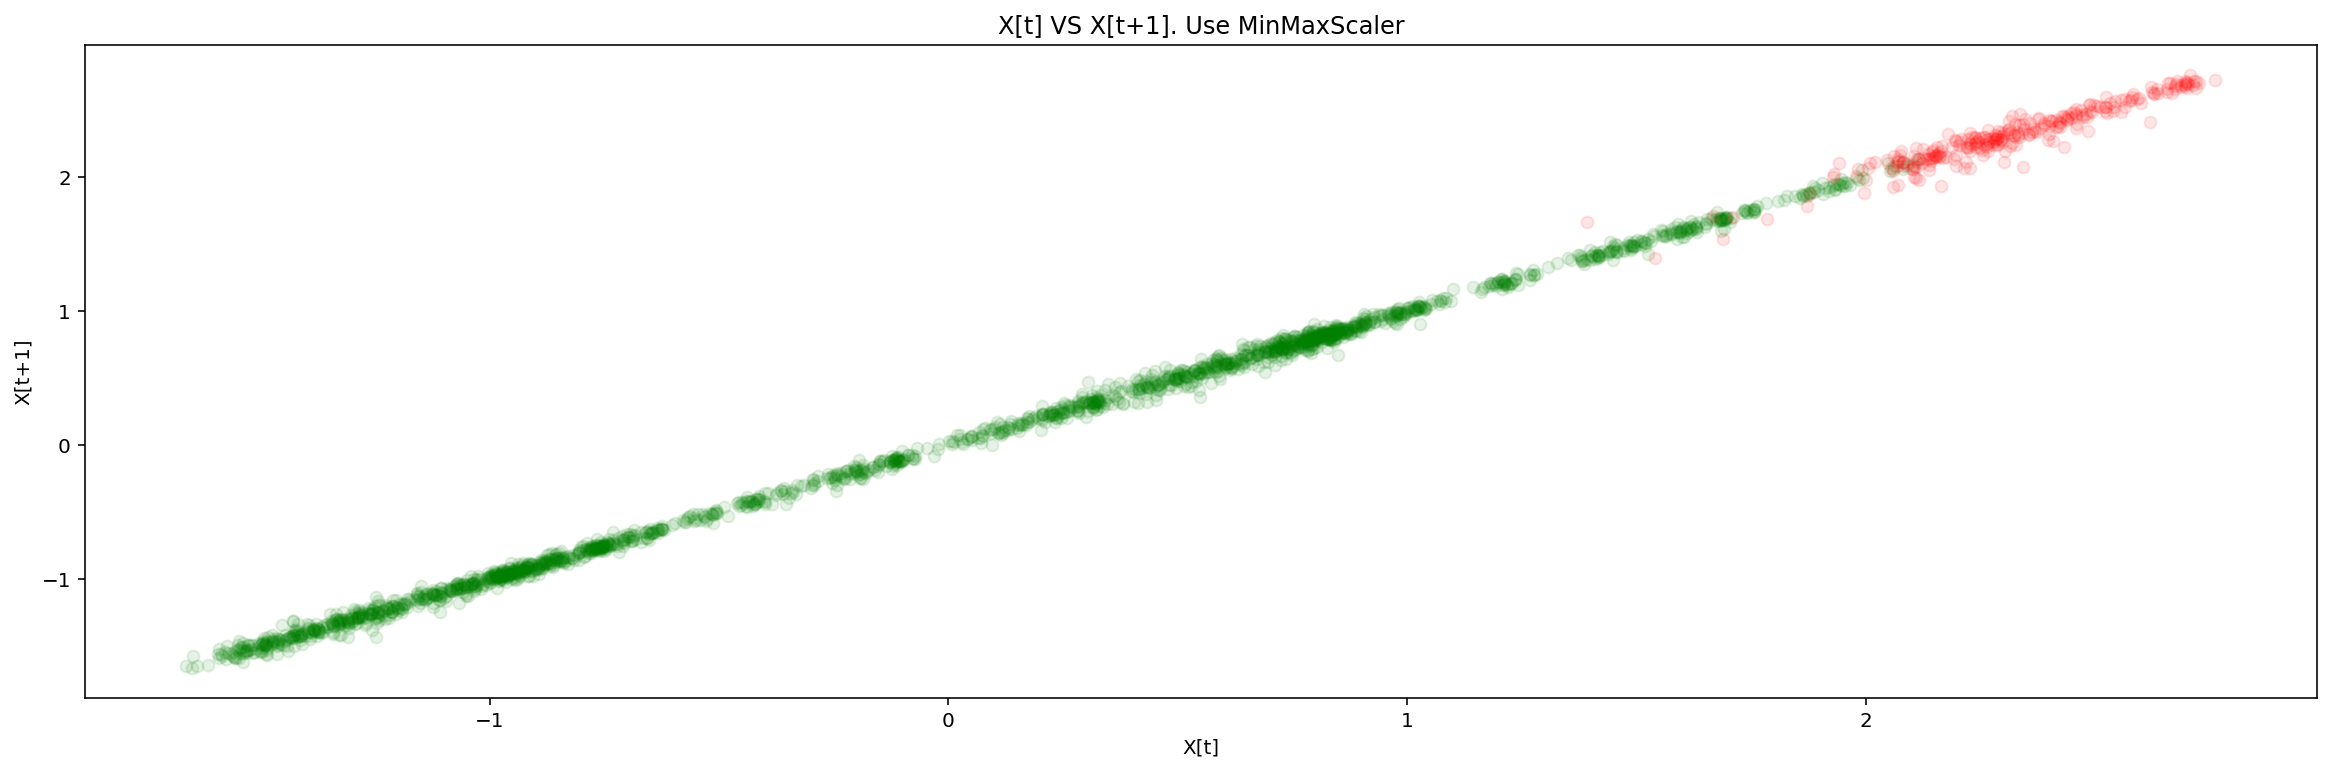

In [34]:
plt.figure(figsize=(20, 6))
plt.xlabel('X[t]')
plt.ylabel('X[t+1]')
plt.title('X[t] VS X[t+1]. Use MinMaxScaler')
plt.scatter(x=X_train[:,[0]], y=X_train[:,[1]], color='green', alpha=0.1)
plt.scatter(x=X_test[:,[0]], y=X_test[:,[1]], color='red', alpha=0.1)
plt.show()

Видно что график опять совершенно не изменился, изменились лишь значения по осям. А пространства признаков как были, так и остались непересекающимися.

А все потому-что скалер для этого и не предназначен.
Он нужен что бы привести признаки в одном датасете у которых разные шкалы к единой шкале. 

### Делаю ряд стационарным. Трансформирую признак к Log_Return

In [35]:
df['Log_Close'] = np.log(df['Close']) 
df['Log_Return'] = df['Log_Close'].diff()
df.dropna(inplace=True)

In [36]:
N_split = 2000
train = df.iloc[:N_split][['Log_Return']]
test = df.iloc[N_split:][['Log_Return']]

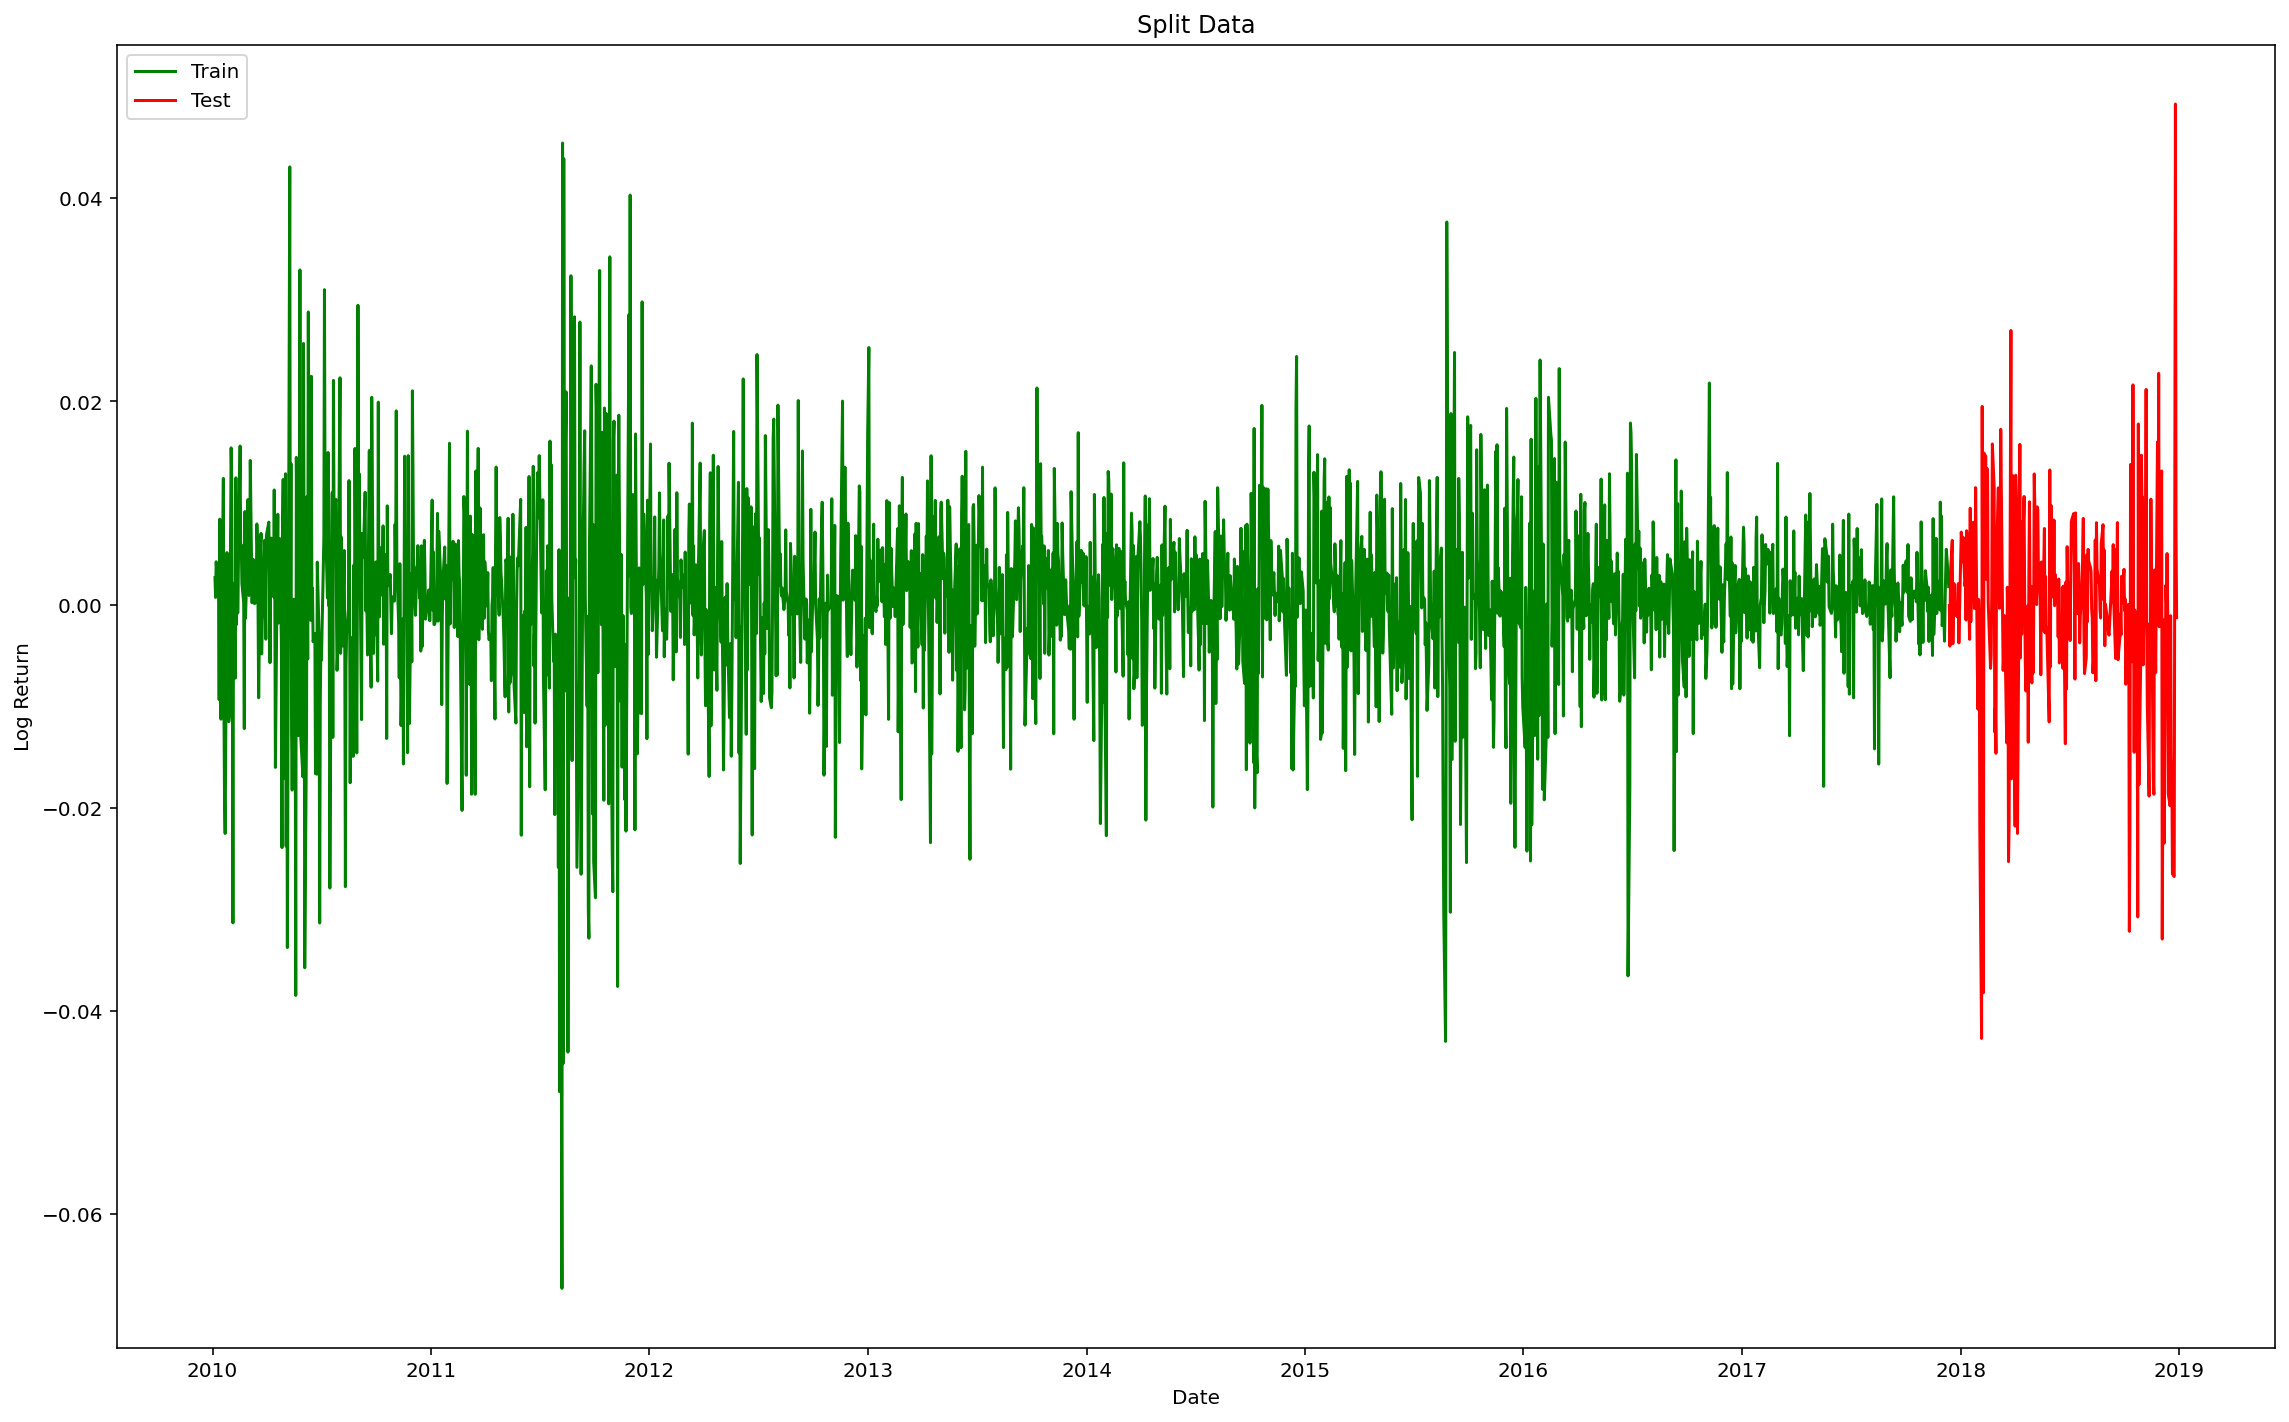

In [37]:
fig, ax = plt.subplots(figsize=(16, 10))

# Convert index and columns to NumPy arrays
index_train = train.index.to_numpy()
close_train = train.to_numpy()
index_test = test.index.to_numpy()
close_test = test.to_numpy()

ax.plot(index_train, close_train, label='Train', color='green')
ax.plot(index_test, close_test, label='Test', color='red')
ax.set_title('Split Data')

plt.ylabel('Log Return')
plt.xlabel('Date')

plt.legend()
plt.tight_layout()
plt.show()

In [41]:
df

,Open,High,Low,Close,Adj Close,Volume,Log_Close,Log_Return
Date,,,,,,,,
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.490204,111579900,4.732948,0.002644
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.555328,116074400,4.733651,0.000704
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.946060,131091100,4.737864,0.004212
2010-01-08,113.889999,114.620003,113.660004,114.570000,93.255348,126402800,4.741186,0.003322
2010-01-11,115.080002,115.129997,114.239998,114.730003,93.385582,106375700,4.742582,0.001396
...,...,...,...,...,...,...,...,...
2018-12-21,246.740005,249.710007,239.979996,240.699997,234.845886,255345600,5.483551,-0.026525
2018-12-24,239.039993,240.839996,234.270004,234.339996,228.640564,147311600,5.456773,-0.026778
2018-12-26,235.970001,246.179993,233.759995,246.179993,240.192596,218485400,5.506063,0.049290


Видно что ряд стал стационарным, еще тест проведу

In [80]:
from statsmodels.tsa.stattools import adfuller

In [81]:
def adf(x, threshold=0.05):
    results = adfuller(x)
    
    print('Test-Statistic:', results[0])
    print('P-Value:', results[1])
    
    if results[1] < threshold:
        print('Stationary!')
    else:
        print('Non-Stationary')

In [82]:
adf(df['Log_Return'])

Test-Statistic: -10.463927724406396
P-Value: 1.3368550654365937e-18
Stationary!


Стационарность подтверждена

In [83]:
train = train.to_numpy()
test = test.to_numpy()

In [84]:
X_train = []
for t in range(len(train) - 1):
    x0 = train[t]
    x1 = train[t + 1]
    X_train.append((x0, x1))

In [85]:
X_test = []
for t in range(len(test) - 1):
    x0 = test[t]
    x1 = test[t + 1]
    X_test.append((x0, x1))

In [86]:
X_train = np.array(X_train)
X_test = np.array(X_test)

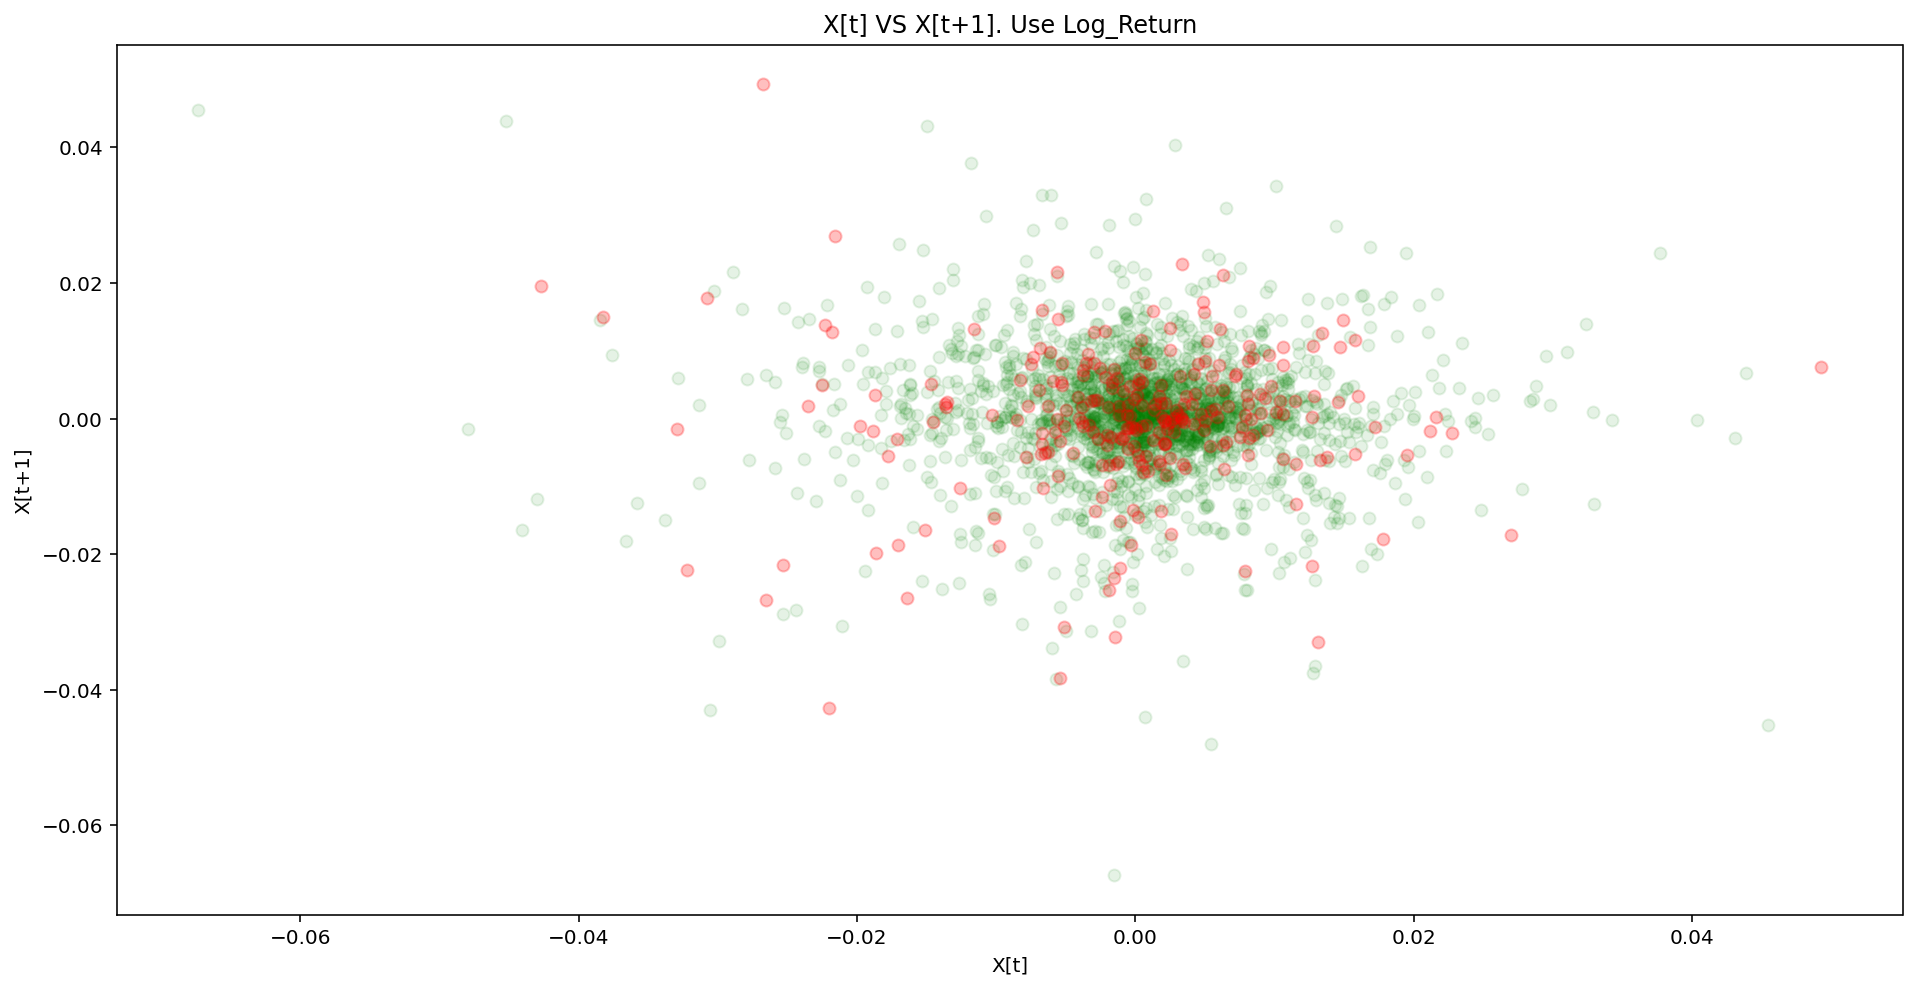

In [88]:
plt.figure(figsize=(16, 8))
plt.xlabel('X[t]')
plt.ylabel('X[t+1]')
plt.title('X[t] VS X[t+1]. Use Log_Return')
plt.scatter(x=X_train[:,[0]], y=X_train[:,[1]], color='green', alpha=0.1)
plt.scatter(x=X_test[:,[0]], y=X_test[:,[1]], color='red', alpha=0.25)
plt.show()

Вооот!

Видно, что подпространства признаков пересекают друг-друга. 

Вернее это одно и тоже подпространство, не вытянутое, без тренда и формации.
Просто облако!